# Analiza nogometnih tekem v top 3 ligah
## Uvoz in obdelava

In [29]:
# Uvozimo vse knjižnice za delo

import pandas as pd
import matplotlib.pyplot as plt

In [30]:
# Uvozimo vse tabele

laliga = pd.read_csv('obdelani-podatki/laliga.csv')
premier_league = pd.read_csv('obdelani-podatki/premier_league.csv')
seriea = pd.read_csv('obdelani-podatki/seriea.csv')


# Dodamo stolpec držav v tabele
esp = len(laliga) * ['La Liga']
ita = len(laliga) * ['Serie A']
eng = len(laliga) * ['Premier League']

laliga['liga'] = esp
seriea['liga'] = ita
premier_league['liga'] = eng

In [32]:
# Pomožna funkcija za pretvorbo datuma v število
import re

vzorec_datuma = (
    r'(?P<mesec>\d{1,2})'
    r'/'
    r'(?P<dan>\d{1,2})'
    r'/'
    r'(?P<leto>\d{1,2})'
)

def izlusci_datum(dat):
    for datum in re.finditer(vzorec_datuma, dat):
        leto = datum['leto']
        mesec = datum['mesec']
        dan = datum['dan']
        return float(leto) + 1 / 12 * (float(mesec) - 1) + 1 / 12 * 1 / 31 * (float(dan) - 1)


# Vse tabele združimo v eno samo

lige = [laliga, premier_league, seriea]
league = pd.concat(lige)

league['datum_num'] = league.datum.apply(izlusci_datum)
league

,kolo,dan,datum,ura,id_domaci,lestvica_domaci,domaca_ekipa,id_gostje,lestvica_gostje,gostujoca_ekipa,zadetki_domaci,tocke_domaci,zadetki_gostje,tocke_gostje,liga,datum_num
0,1,petek,8/16/19,9:00 PM,621,11,Athletic,131,2,FC Barcelona,1,3,0,0,La Liga,19.623656
1,1,sobota,8/17/19,5:00 PM,940,17,Celta de Vigo,418,1,Real Madrid,1,0,3,3,La Liga,19.626344
2,1,sobota,8/17/19,7:00 PM,1049,9,Valencia,681,7,Real Sociedad,1,1,1,1,La Liga,19.626344
3,1,sobota,8/17/19,8:00 PM,237,19,RCD Mallorca,1533,14,SD Eibar,2,3,1,0,La Liga,19.626344
4,1,sobota,8/17/19,9:00 PM,1244,18,CD Leganés,331,10,CA Osasuna,0,0,1,3,La Liga,19.626344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,38,nedelja,8/2/20,6:00 PM,2722,20,SPAL,430,10,Fiorentina,1,0,3,3,Serie A,20.586022
376,38,nedelja,8/2/20,8:45 PM,252,17,Genoa,276,9,Hellas Verona,3,3,0,0,Serie A,20.586022
377,38,nedelja,8/2/20,8:45 PM,1005,18,Lecce,130,11,Parma,3,0,4,3,Serie A,20.586022
378,38,nedelja,8/2/20,8:45 PM,1025,12,Bologna,416,16,Torino,1,1,1,1,Serie A,20.586022


## Overjanje veljavnosti hipotez
### Hipoteza 1
Kot prvo hipotezo hočemo pokazati, da domača ekipa zmaga v več primerih kot gostujoča.

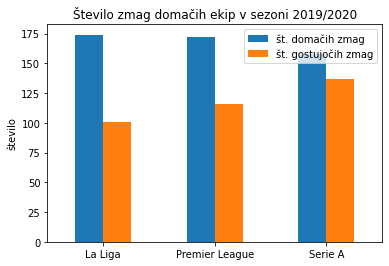

In [33]:
zmage_domacih = league[league.tocke_domaci > 1][['liga', 'tocke_domaci']]
zmage_gostov = league[league.tocke_domaci < 1][['liga', 'tocke_gostje']]

df1 = zmage_domacih.groupby('liga').count()
df2 = zmage_gostov.groupby('liga').count()

df = pd.concat([df1,df2], axis=1)
df = df.rename(columns={"tocke_domaci": "št. domačih zmag", "tocke_gostje": "št. gostujočih zmag"})

graf1 = df.plot.bar(rot=0) 
graf1.set(title='Število zmag domačih ekip v sezoni 2019/2020', ylabel='število', xlabel='');


V zgornjem grafu je jasno vidno, da domače ekipe v vseh treh ligah zmagujejo večkrat kor gostujoče ekipe. Razlika je sicer največja v španski La Ligi, precej majhna pa je v italijanski Serie A.<br> Hipoteza 1 je torej potrjena: **Domače ekipe zmagujejo bolj pogosto kot gostujoče.**

### Hipoteza 2
Kot drugo hipotezo bom želel pokazati, da prisotnost navijačev dejansko vpliva na končni rezultat. Odstotek zmag domačih ekip po korona premoru bi se torej moral zmanjšati. Pred tem odmorom so namreč domače ekipe imele spodbudo navijačev na njihovih tekmah, po njem pa so zaradi korona restrikcij tribune morale ostati prazne. <br>
V Angliji se je odmor začel 4.1.2020 in končal 16.6.2020, v Italiji je trajal od 10.3.2020 do 21.6,2020, v Španiji pa od 4.1.2020 do 2.6.2020.

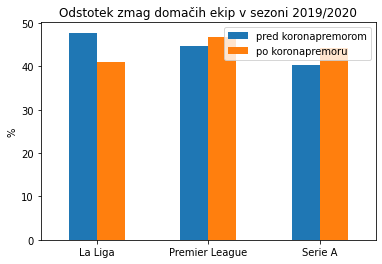

In [36]:
mejni_datum = izlusci_datum('3/15/20')

predkoronski = league[league.datum_num < mejni_datum][['liga', 'tocke_domaci']]
pokoronski = league[league.datum_num > mejni_datum][['liga', 'tocke_domaci']]

df1 = predkoronski.groupby('liga').count()
df1 = df1.rename(columns={"tocke_domaci": "allpred"})
df2 = pokoronski.groupby('liga').count()
df2 = df2.rename(columns={"tocke_domaci": "allpo"})

df3 = predkoronski[predkoronski.tocke_domaci > 1].groupby('liga').count()
df3 = df3.rename(columns={"tocke_domaci": "winpred"})
df4 = pokoronski[pokoronski.tocke_domaci > 1].groupby('liga').count()
df4 = df4.rename(columns={"tocke_domaci": "winpo"})

df = pd.concat([df1,df2,df3,df4], axis=1)
df['pred koronapremorom'] = df.winpred / df.allpred * 100
df['po koronapremoru'] = df.winpo / df.allpo * 100

graf2 = df[['pred koronapremorom', 'po koronapremoru']].plot.bar(rot=0) 
graf2.set(title='Odstotek zmag domačih ekip v sezoni 2019/2020', ylabel='%', xlabel='');

Kot vidimo v zgodnjem grafu hipoteza nekako še drži za La Ligo, pri Premier League in Serie A pa jo lahko ovržemo. Odstotek zmag domačih ekip je bil namreč kljub odsotnosti navijačev v teh dveh ligah celo večji kot navadno. Razlog za to je najbrž dejstvo, da navijači niso vedno samo pozitivna okoliščina temveč včasih tudi razlog za pritisk na igralcih. <br>
Hipoteza 2 mora biti zato ovržena: ** Odsotnost navijačev ne vedno zmanjšuje možnosti domačih ekip za zmago. **